In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
from datetime import date
from datetime import timedelta


In [ ]:
# Authenticate to Google Cloud
try: auth
except:
  !apt update
  !pip install pandas google-cloud-storage

  import pandas as pd
  from google.colab import auth

print (pd.__version__)
auth.authenticate_user()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,479 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,288 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 h

In [ ]:
query = '''
SELECT a.TestTime,
raw.ClientIP,
client.Geo.Latitude as client_latitude,
client.Geo.Longitude as client_long,
client.Geo.City AS client_city,
client.Geo.PostalCode AS client_postal,
client.Geo.CountryCode AS client_country,
client.Network.ASNumber,
client.Network.ASName,
raw.ServerIP,
server.Site,
server.Machine,
server.Geo.Latitude as server_latitude,
server.Geo.Longitude as server_longitude,
server.Geo.City AS server_city,
server.Geo.CountryCode AS server_country,
a.LossRate,
a.MinRTT,
a.MeanThroughputMbps
FROM `measurement-lab.ndt.ndt7`
WHERE date <= "2025-10-30" AND date >= "2025-08-01"
AND client.Geo.CountryCode = "NZ"
'''

df = pd.read_gbq(query, project_id="measurement-lab")





/tmp/ipython-input-1909759305.py:25: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query, project_id="measurement-lab")


In [ ]:
display(df.head(2))
print("Number of Speed Tests in the date range: " + str(len(df)))


,TestTime,ClientIP,client_latitude,client_long,client_city,client_postal,client_country,ASNumber,ASName,ServerIP,Site,Machine,server_latitude,server_longitude,server_city,server_country,LossRate,MinRTT,MeanThroughputMbps
0,2025-10-07 18:58:54.297676+00:00,114.110.35.125,-42.0009,173.9980,None,None,NZ,18119,ACSDATA Network Operations,203.5.76.165,syd03,mlab3,-33.9461,151.17700,Sydney,AU,0.050841,146.307,76.278793
1,2025-10-07 04:03:34.053397+00:00,202.92.219.137,-36.8504,174.7675,Auckland,1010,NZ,56186,Digital Island Limited,77.67.115.101,mad04,mlab3,40.4719,-3.56264,Madrid,ES,0.000000,280.490,62.951772


Number of Speed Tests in the date range: 3095881


In [ ]:
# Create a new data frame with the average Mbps for each postal code
df_postal = ( df.groupby(['client_latitude','client_long'])['MeanThroughputMbps'].
  agg(median='median', count='count').
  reset_index()
)
df_postal.columns = ['client_latitude','client_long','MedianThroughputMbps', 'CountOfTests']
display(len(df_postal))
display(df_postal.head(2))


476

,client_latitude,client_long,MedianThroughputMbps,CountOfTests
0,-46.596,168.3339,70.893085,31
1,-46.450,168.4000,82.398719,2291


In [ ]:
import folium
from folium.plugins import FastMarkerCluster

# Define 10-step color gradient
COLORS = [
    "#FF0000", "#FF4000", "#FF8000", "#FFBF00", "#FFFF00",
    "#BFFF00", "#80FF00", "#40FF00", "#00FF00", "#00CC00",
]

# Define thresholds (adjust as needed)
THRESHOLDS = np.linspace(0, 200, len(COLORS))

def get_color(speed):
    # find index of closest threshold not greater than speed
    idx = np.searchsorted(THRESHOLDS, speed, side="right") - 1
    idx = max(0, min(idx, len(COLORS) - 1))
    return COLORS[idx]

# Center map near Nelson
m = folium.Map(location=[-41.27, 173], zoom_start=5, tiles="CartoDB positron")

# Plot points with color based on speed
for _, row in df_postal.iterrows():
    speed = row["MedianThroughputMbps"]
    count = row["CountOfTests"]
    color = get_color(speed)
    # print(row.client_city, row.MeanThroughputMbps, color)
    if count < 10:
      radius = 1
    elif count < 100:
      radius = 3
    elif count < 1000:
      radius = 5
    else:
      radius = 7

    folium.CircleMarker(
        location=(row.client_latitude, row.client_long),
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{speed:.1f} Mbps\n{count} Tests Included",
    ).add_to(m)

m


In [ ]:
# Get daily median across the country
df_date = df.groupby(['TestTime'])['MeanThroughputMbps'].median().reset_index()


[None 'Auckland' 'Hamilton' 'Richmond' 'Wellington' 'New Plymouth'
 'Gisborne' 'Brightwater' 'Dunedin' 'Napier City' 'Blenheim'
 'Christchurch' 'Hastings' 'Albany' 'Motueka' 'Cambridge'
 'Palmerston North' 'Lower Hutt' 'Otara' 'Morrinsville' 'Flaxmere'
 'Queenstown' 'Swannanoa' 'Hokitika' 'Taupo' 'Forrest Hill' 'Masterton'
 'Porirua' 'Cloverlea' 'Wanaka' 'Marton' 'Invercargill' 'Whanganui'
 'Greytown' 'Nelson' 'Wakefield' 'Tauranga' 'Alexandra' 'Rotorua'
 'Ashburton' 'Rakaia' 'Mapua' 'Waipukurau' 'Gore' 'Timaru' 'Rangiora'
 'Waitara' 'Warkworth' 'Martinborough' 'Takaka' 'Havelock North'
 'Mount Maunganui' 'Whangarei' 'Papakura' 'Patea' 'Makara' 'Whakatane'
 'Upper Hutt' 'Kaiapoi' 'Levin' 'Tirau' 'Redcliffs' 'Churton Park'
 'Feilding' 'Mangakakahi' 'Stratford' 'Upper Moutere' 'Putaruru' 'Clive'
 'Amberley' 'Te Puke' 'Strowan' 'Carterton' 'Westport' 'Lyttelton'
 'Cromwell' 'Oamaru' 'Culverden' 'Tasman District' 'Whangamata'
 'Titahi Bay' 'Te Awamutu' 'Taihape' 'Leeston' 'Papamoa' 'Waikat

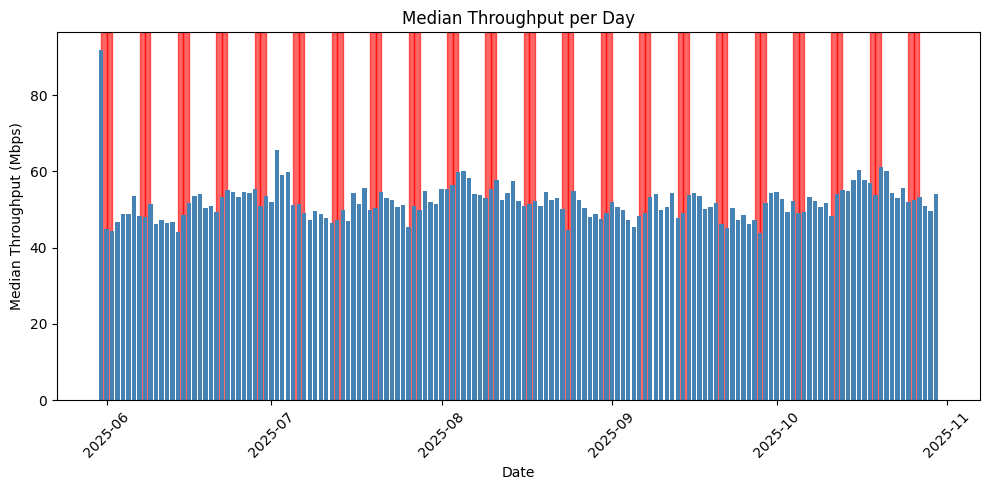

In [ ]:
# Let's get the median download speed per day, then display it as a bar chart for a two week span in October
df['date'] = df['TestTime'].dt.date
df_date = df.groupby(['date'])['MeanThroughputMbps'].median().reset_index()
df_date.columns = ['date', 'MedianOfMeanThroughput']
# Sort by date
df_date = df_date.sort_values(by='date')
# display(df_date.head(10))
# Bar Chart
# Create figure
fig, ax = plt.subplots(figsize=(10,5))

# Plot bars
ax.bar(df_date['date'], df_date['MedianOfMeanThroughput'], color='steelblue')

# Shade weekends
for date in df_date['date']:
    if date.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        ax.axvspan(date,
                   date + pd.Timedelta(hours=24),
                   color='red', alpha=0.6, zorder=0)

# Labels and formatting
ax.set_title("Median Throughput per Day")
ax.set_xlabel("Date")
ax.set_ylabel("Median Throughput (Mbps)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

,date,MedianOfMeanThroughput
0,2025-05-31,91.882622
1,2025-06-01,44.900566
2,2025-06-02,44.238455
3,2025-06-03,46.624512
4,2025-06-04,48.924344
5,2025-06-05,48.818757
6,2025-06-06,53.587775
7,2025-06-07,48.398059
8,2025-06-08,48.046681
9,2025-06-09,51.521042


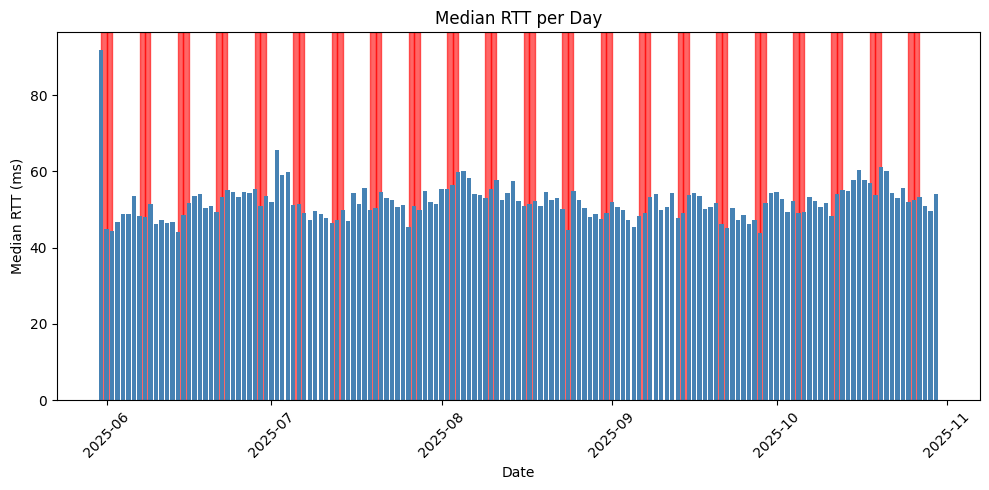

In [ ]:
# Let's get the median download speed per day, then display it as a bar chart for a two week span in October
df['date'] = df['TestTime'].dt.date
df_rtt = df.groupby(['date'])['MinRTT'].median().reset_index()
df_rtt.columns = ['date', 'MinRTT']
# Sort by date
df_rtt = df_date.sort_values(by='date')
display(df_rtt.head(10))
# Bar Chart
# Create figure
fig, ax = plt.subplots(figsize=(10,5))

# Plot bars
ax.bar(df_rtt['date'], df_rtt['MedianOfMeanThroughput'], color='steelblue')

# Shade weekends
for date in df_rtt['date']:
    if date.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        ax.axvspan(date,
                   date + pd.Timedelta(hours=24),
                   color='red', alpha=0.6, zorder=0)

# Labels and formatting
ax.set_title("Median RTT per Day")
ax.set_xlabel("Date")
ax.set_ylabel("Median RTT (ms)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()